# Airbnb Reviews Dataset

The dataset you'll be working with in this exercise is a sample of Airbnb Review data. Airbnb provides all kinds of data concerning quarterly or monthly data of residences in big cities all around the world. The data can be downloaded for free at <a href="http://insideairbnb.com/get-the-data/">inside airbnb</a>.

The part of the data relevant to this exercise, as mentioned above, relates to reviews. Because of airbnb's generousity the review datasets for the different cities contain millions of entries which might be a little too much for your first attempt at analyzing text only.

For this reason a random subset of 25,000 entries has been prepared for you. In comparison to the original dataset this might seem like a small dataset but some of the following steps to analyze this data might take a couple of seconds or even minutes to compute, depending on your hardware.

The dataset in `sample_reviews.csv` is a subset of reviews of airbnbs in the city of Berlin. It also has been prefiltered to only contain reviews which could be identified as English by <a href="https://pypi.org/project/langdetect/"> Nakatani Shuyo's language detection library</a>.

### Exercise:

- Import necessary package to read `sample_reviews.csv`
- Read `sample_reviews.csv` and create a `pandas.DataFrame` with the review data. Note that it has an integer index in its first column.
- Inspect the data using the DataFrame's functionality.

In [7]:
#Import necessary package
import pandas as pd
import os

#Read sample of review data
file_path = os.path.join(os.getcwd(), 'sample_reviews.csv')

df = pd.read_csv(file_path)

#Inspect the data by using the DataFrame's functionality
print(df.head())
print(df.info())
print(df.describe())


Reading data from: /Users/maximus/Documents/git/digital_business/Aufgabe5/sample_reviews.csv
   Unnamed: 0  listing_id                  id        date  reviewer_id  \
0      131865     7653603  477290575321875162  2021-10-20    216852762   
1      215150    16543844           239346564  2018-03-01     11840635   
2      159624    11029458            97291090  2016-08-26      6445915   
3      163018    11564181           245451038  2018-03-22    112821276   
4      415972    51964429  472199344498908313  2021-10-13      2480555   

  reviewer_name                                           comments  
0        Kaycee  Great location, host was very accommodating to...  
1        Hilary  This is a beautiful apartment which has been v...  
2          Anna  Great place. Very comfortable. Plenty of space...  
3       Adelina  This is a great apartment in terms of location...  
4         Peter  Check in with Jakub was great. He is a super n...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex

# Vectorizing Text Data

As you might have guessed already the only column of the `sample_reviews` data is the `comments` column which contains the text of a given review. As the machine learning models you got to know over the time of the semester don't handle blobs of text as only input very well some kind of further transformation is needed.

One of the less complex ways to represent blobs of text in a way a machine can understand is to utilize CountVectorization. This technique seperates the different words of a text from each other and counts their occurence in the given text. At this point it is important to know in which language the text you will be transforming is written. If you don't know the language it can be detected  by language detectors like the one mentioned above. In this case the language recognition and filtering has already been done for you. All reviews in the data were detected as English.

The next step after figuring out the language is to delete stop words from the texts. This is a very important step in almost all analysis of natural language. Stop words are the words that are most frequently used in a language and therefore might not be really carrying a lot of information to analyse. Some examples of stop words in the English language are: `the`, `is`, `which` or `on`. These words are helpful for humans to communicate information fluently and more understandable but in most cases do not carry enough information to be of high importance for a machine learning algorithmn.

The goal of this analysis is clustering the airbnb reviews, so what's needed is the core information of a review which does not include stop words. Another argument to delte stop words is that because of their frequency they might not be a good indicator to seperate the data anyway.

One last important concept is the `max_features` attribute of the `CountVectorizer`. It limits the number of dimensions of the transformed dataset to a specified amount and only lists the most frequent words in a text aside from the stopwords. This is important when transforming text data because there is really no theoretical upper bound to how many different words occur in a text. This can lead to enormous numbers of features in the transformed dataset which then increases the risk of facing the negative impact of the curse of dimensionality.

### Exercise
- Import `CountVectorizer` from scikit-learn's `feature_extraction.text` module.
- Initialize the `CountVectorizer` with `english` stop words and a maximum number of `100` features.
- Fit the `CountVectorizer` to the data and transform in the same line using `fit_transform()`. Pass only the `comments` column of the DataFrame containing the reviews.
- Save the feature names in variable `words` by calling the `CountVectorizer`'s `get_feature_names_out()` function.
- Create a `pd.DataFrame` for the transformed features using the output of the `CountVectorizer` and calling its `.toarray()` function as data. Pass the feature names variable to the `columns` argument.
- Print the first few rows of the new DataFrame to see if it worked.

In [8]:
#Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Initialize CountVectorizer
count_vect = CountVectorizer(stop_words='english',max_features=100)

#Apply CountVectorizer
data_count = count_vect.fit_transform(df['comments'])

#Create DataFrame
words = count_vect.get_feature_names_out()
data = pd.DataFrame(data_count.toarray(), columns=words)
#Print first few rows of vectorized review data
print(data.head())

   airbnb  amazing  apartment  area  arrival  away  bahn  bars  bathroom  \
0       1        0          0     0        0     0     0     0         0   
1       0        0          1     0        0     0     0     0         0   
2       0        0          0     0        1     0     0     0         0   
3       0        0          1     0        0     0     0     0         0   
4       0        0          1     1        0     0     0     0         0   

   beautiful  ...  super  thank  thanks  time  transport  visit  walk  \
0          0  ...      0      0       0     0          0      0     0   
1          1  ...      0      0       0     0          0      0     0   
2          0  ...      0      0       2     1          1      0     0   
3          0  ...      0      0       0     0          0      0     0   
4          0  ...      1      0       0     0          0      0     0   

   walking  welcoming  wonderful  
0        0          0          0  
1        0          0          1  

# Dimensionality Reduction

Although we already set the `CountVectorizer`'s `max_feature` argument to just the hundred most frequent words in the corpus of reviews, hundred dimensions are a lot of dimensions and will probably increase the computation time of any given clustering algorithmn because distance needs to be calculated in every dimension.

A way of dealing with this is reducing the dimensionality of a dataset but preserving as much information as possible. Probably one of the oldest methods (invented in 1901 by Karl Pearson) that is still used in data science is called `Principal Components Analysis (PCA)`. A key part of its longevity is its strong theoretical foundation and its efficency in terms of processing time. It transforms metrically scaled data into a set of principal components. These resulting principal components are sorted by the amount of variance they explain in the original data. Then only the n components of these are selected that explain the most or a desired ratio (e.g. 95 percent or 90 percent) of the variance of the original dataset.

As you might have noticed the PCA interprets the information in a dataset as its variance and therefore aims to represent as much of the variance of the original dataset as possible in the reduced dataset. One of the downsides of this technique is that it only operates on the level of correlations in the dataset which means only linear relationships in the original data can be modelled.

The computational efficiency is due to the calculation of principal components being a singular value decomposition which is a fairly simple matrix multiplication of the original data's variance-covariance matrix and the original data matrix itself. Those types of computations can be implemented really efficiently using `numpy` and it's under the hood `C` calculations.

An important step before utilizing the `Principal Components Analysis` is scaling the data by using e.g. `sklearn`'s standard scaler.

### Exercise
- Import `PCA` from `sklearn`'s `decomposition` module.
- Initialize a `PCA` object. You want it to output the `10` components that explain the most variance in the original data. Also set the `random_state` to `123` for reproducibility.
- Fit the `PCA` object to the count vectorized data.
- Transform the count vectorized data into the ten principal components that explain the most of its variance and save the result to a new `pd.DataFrame`.
- Print the array of explained variance ratio and its sum using the `PCA` objects `explained_variance_ratio_` attribute.
- Print the first few rows of the reduced dataset to see if it worked.
- Can explain why you could use the `PCA` in this dataset although it represents text, which is not metrically scaled?
- Why didn't you need to use the `StandardScaler` before utilizing the `PCA`'s `.fit()` and `.transform()` methods on the dataset?

In [9]:
#Import PCA
from sklearn.decomposition import PCA

#Initialize PCA object for 10 Principal Components
pca = PCA(n_components=10,random_state=123)

#Fit PCA object to vectorized review data
pca.fit(data)
data_reduced = pd.DataFrame(pca.transform(data))

#Print amount of explainend variance by first 10 principal components
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

#Print first few rows of reduced data
print(data_reduced.head())

[0.20334259 0.05941574 0.04527802 0.04092117 0.02947994 0.02673527
 0.02300322 0.02196537 0.02044888 0.01887263]
0.4894628290731656
          0         1         2         3         4         5         6  \
0 -0.686254 -0.274829  0.147040  1.099121  0.073188 -0.104956 -0.104772   
1 -0.460930  0.563041 -0.603279 -0.087155 -0.751884 -0.215609  0.583056   
2 -0.413809  0.202802  0.991113 -0.086556 -0.049840  0.066975 -0.737632   
3  0.591477  0.401083 -0.198022  0.590827  0.882821 -0.187211 -0.160846   
4  1.564737  0.536618  0.239617  1.237935  0.866219 -0.371349  0.752989   

          7         8         9  
0  0.122283 -0.109388  0.042011  
1  0.382702 -0.127497  0.183824  
2 -0.181169  0.948895 -0.202515  
3  0.999262  1.411784  0.101628  
4  0.204411 -0.800725 -0.731669  



1.

es wird nicht das wort/text per se verwendet, sondern eher das vorkommen eines wortes in einem review

2.

Alle features waren zählungen der wörter und somit in einer vergleichbaren Werterange, daher musste keine Anpassung erfolgen


# K-Means Clustering

As already mentioned the target of this analysis is clustering the sample of Airbnb reviews in the city of Berlin and interpreting the results. Clustering is, as well as most algorithmns for dimensionality reduction, part of the machine learning discipline of `unsupervised learning`. That means that the dataset does not contain values of the target variable.

You can imagine the analysis you are doing right now as a classification problem but you don't have any information about the affiliation to a class of any of the dataset entries. The best way to deal with this is to take an educated guess on the number of classes and the affiliation of every dataset to theses classes.

One way to take that guess is by determining a number of classes `k` and choosing `k` random points in the dataset. The next step is to calculate the distances between every entry of the dataset and the random points and assigning each dataset entry to the random point it has the lowest sum of distances (one distance for every feature) to. The third step is updating the random `k` points by moving it to the point in the dataset where it has to lowest sum of distances to all the point that were assigned to it in the previous step. It is now the `clustering center` or `centroid` of these points. The second and thiord step are then repeated until the `centroids` aren't updated anymore or a number of maximal iterations is reached. 

A method to improve the initial guess of random points is to plot a clustering metrics' values to different possible values for `k` as the so called `elbow plot`. The x-axes shows the possible values for `k` and the y-axes shows the value of the clustering metric e.g. `Silhouette Score`. The best number for `k` is then determined by looking for the most obvious bend in the resulting line.

The above mentioned metric of `Silhouette Score` or `Silhouette Coefficient` is a ratio of distance between the mean intra cluster distance and the distance between a datapoint and the nearest cluster it is not a part of. Most of the other clustering metrics use some kind of distance ratio in-between datapoints in a cluster and between clusters or their centroids to determine if one cluster result is better than the other.

### Exercise:

- Import `KMeans` from scikit-learn's `cluster` module.
- Import `silhouette_score` and `calinski_harabasz_score` from `sklearn.metrics`.
- Import `matplotlib.pyplot`.
- Complete the loop to calculate the silhouette scores for k = [2,3,4,5,6] and save it to a list.
- Call `matplotlib.pyplot`'s `.subplots()` function and set the figsize width to `16` inches and the height to `10` inches. Give the `title`,`xlabel` and `ylabel` fitting values.
- Create the same elbow plot using the `calinski_harabasz_score`
- Choose a `k` for fitting the k-means algorithmn on the data based on the implications of the elbow plots.
- Fit the `KMeans` object with the chosen `k` on the reduced dataset.
- Explain what ratio `calinksi_haberasz_score` calculates and how it differs from silhouette score.
- Can you explain what the `max_iter` argument when initializing a k-means object does?

2
3
4
5
6


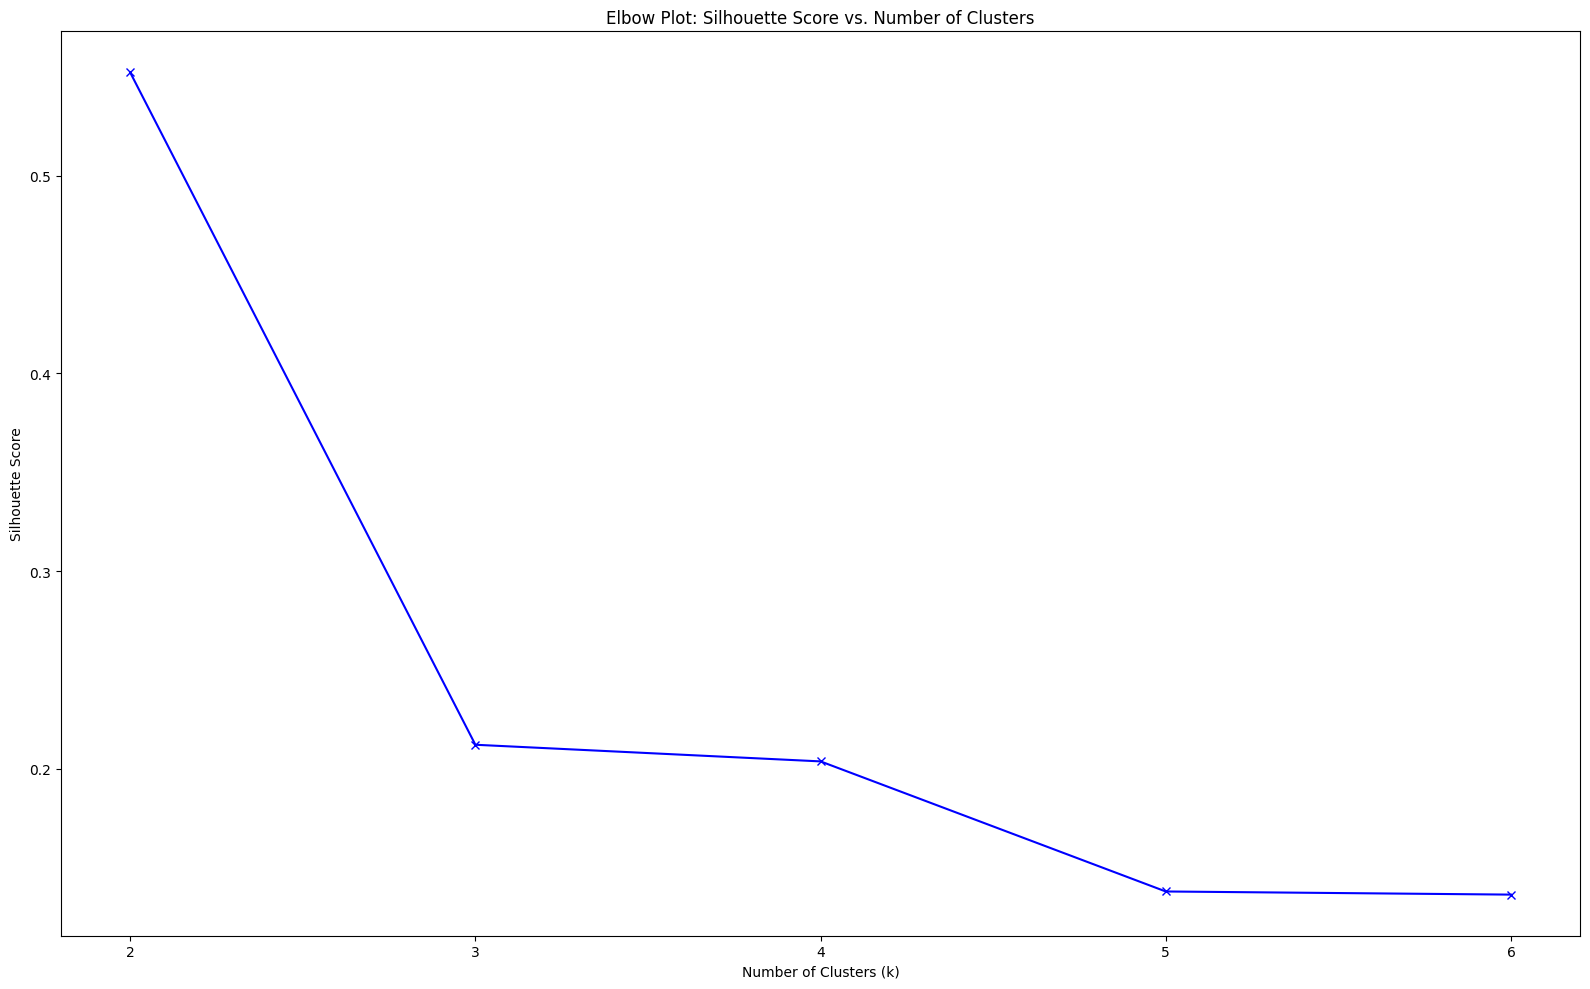

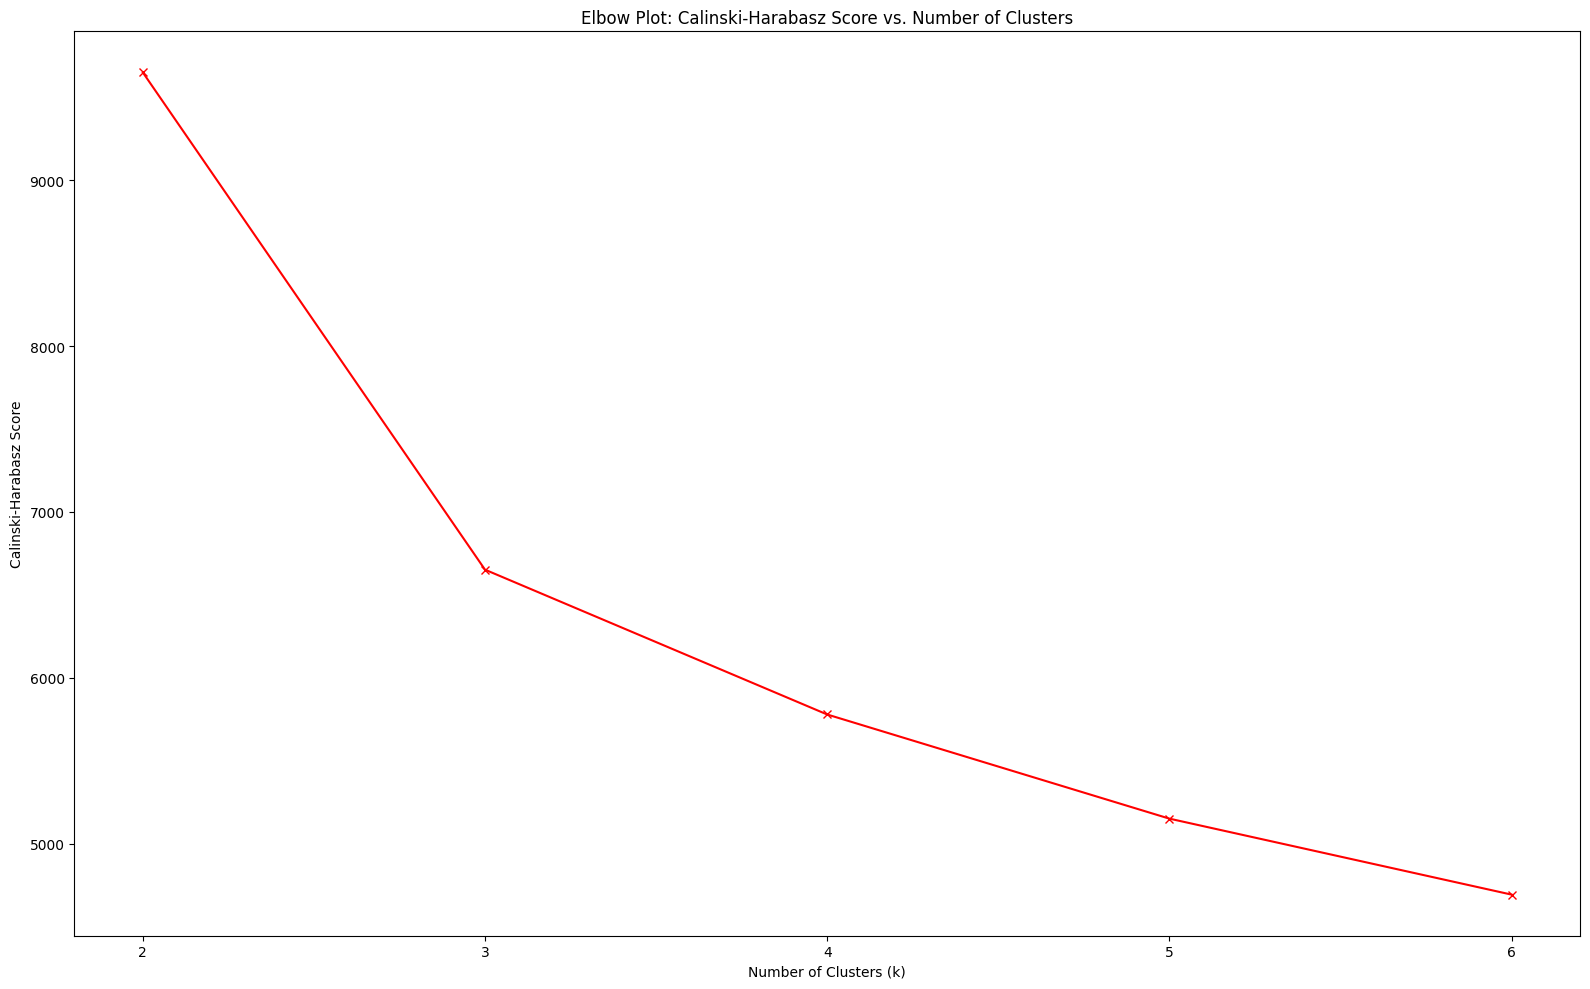

In [12]:
#Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt


#Initialize k-means clustering object
kmeans = KMeans()

#Elbow Plot for k in kmeans with silhouette score
silhouette_scores = []

for k in range(2, 7):
    print(k)
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')
    km.fit(data_reduced)
    silhouette_scores.append(silhouette_score(data_reduced, km.labels_))

#Show Plot and Set labels
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(range(2, 7), silhouette_scores, 'bx-')
ax.set_title('Elbow Plot: Silhouette Score vs. Number of Clusters')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

#Elbow Plot for k in kmeans with calinski haberasz score
ch_scores = []

for k in range(2, 7):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')
    km.fit(data_reduced)
    ch_scores.append(calinski_harabasz_score(data_reduced, km.labels_))

#Show Plot and Set labels
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(range(2, 7), ch_scores, 'rx-')
ax.set_title('Elbow Plot: Calinski-Harabasz Score vs. Number of Clusters')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Calinski-Harabasz Score')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

#Choose k for K-Means algorithmn
km = KMeans(n_clusters=3, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')

#Fit k-means model
km_fitted = km.fit(data_reduced)

# Antworten zu K-Means Clustering

1.

- **Calinski-Harabasz**: Verhältnis zwischen Between-Cluster-Streuung und Within-Cluster-Streuung. Höherer Wert = bessere Trennung. Nutzt Zentroide, recheneffizient.
- **Silhouette Score**: Misst für jeden Punkt die Ähnlichkeit zum eigenen vs. nächstem Cluster. Rechenintensiver.


2.
-maximale Anzahl an Iterationen bevor der Algorithmus stoppt

# Visualizing Clustering Results

Other than calculating clustering metrics there is only one other way to calculate the quality of the results. That is visualizing clustering results and checking if the result seem to be following a natural pattern in the data.

Of course one of the main problems of this is data with more than three dimensions is that it can not be visualized in a conventional python plot. The answer is of course dimensionality reduction. For the analysis you are doing right now it is most practical to use `PCA` because that is the only dimensionality reduction technique you know at this point.

Note that plain old `PCA`, although being efficient and well justified theoratically, is not considered the best method to visualize high dimensional data. When interpreting visualizations of principal components you need to remember it only considers linear dependencies. `PCA` transforms the data into perpendicular principal components which can, especially when only visualizing two components in a plot, cause major distortions of the real relationships in the dataset. Some of the more sophisticated visualization methods that can visualize even nonlinear relationships of highdimensional data are `Kernel PCA` or `t-sne`.

For now let's settle on visualizign the first two principal components colored by the cluster they were assigned to by `KMeans`.

### Exercise:
- Import `seaborn` and `numpy`.
- Initialize a `PCA` object that reduces data to only two principal components.
- Fit and transform the review data utilizing the ´PCA´ objects' methods.
- Create a `pd.DataFrame` from the reduced dataset and give the columns fitting names.
- Concatenate the clustering result to the DataFrame utilizing the `KMeans` objects' `.labels_` attribute. Give the new column a fitting name.
- Give the scatterplot a fitting title and set its width to `16` and its height to `10`.
- Create and display a `seaborn.scatterplot` by passing the right column names to the `x`,`y` and `hue` arguments. Also pass the DataFrame you just created to the `data` argument.
- Complete the loop to print for random reviews in every cluster. Pass the length of the dataset to `numpy`'s `random.choice` function.
- Complete the code to create a barplot of the amount of words in every cluster.
- Interpret the plots and evaluate results. Did you get a good clustering result? Can you see any promising patterns? Either way give reasons for your answer.
- Can you think of a kind of analysis that might have been more reasonable regarding the fact that the analysed dataset consists only of blobs of text?

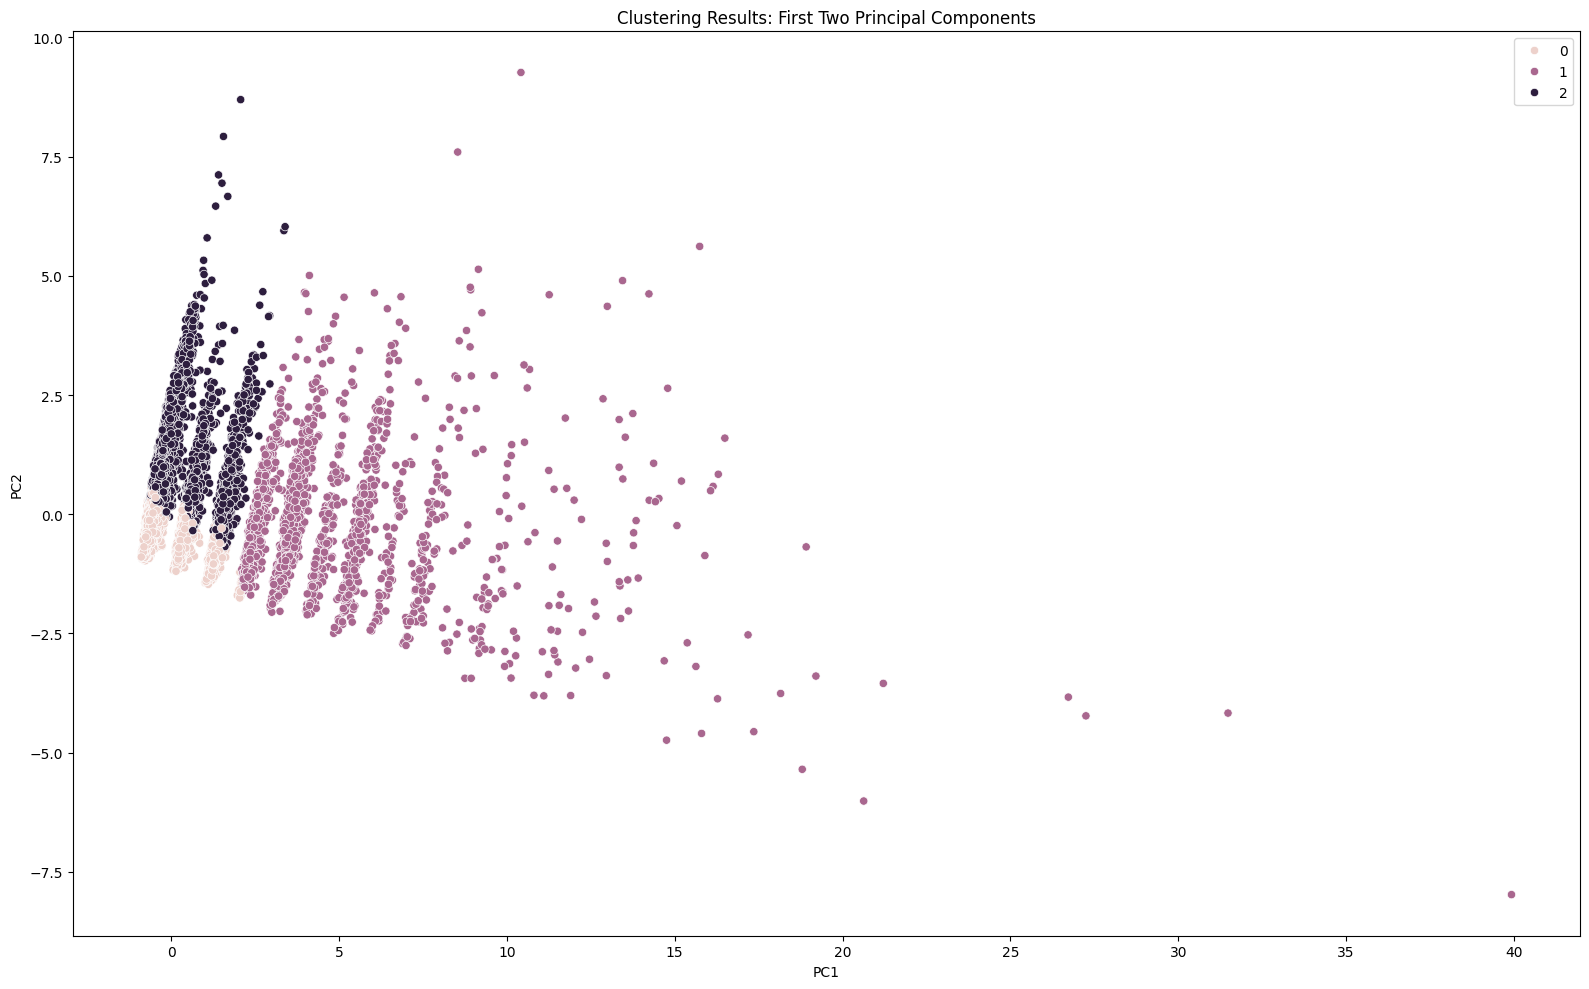

Data of sample:  Absolutely perfect! Amazing swimming pool and sauna. Caring and helpful staff. Historic building. Room very well furnished. We warmly recommend!
Cluster of sample:  0
Data of sample:  Katherina's place is very well-located, is very spacious and has great facilities. She is a great host. I highly recommend her place.
Cluster of sample:  0
Data of sample:  I liked the place and Sabrina was  a good host... I would come here the next time I come to Berlin. 
Cluster of sample:  0
Data of sample:  The room was super cute and the flat has such good vibes! Ela is very kind and helpful, a very interesting person and always smiling :)
Cluster of sample:  0

Data of sample:  The apartment is a great space and in a good location in Friedrichschain. The apartment has great views of Boxhagener Platz and is about a 10 minute walk to the Warschauer Straße U-Bahn and S-Bahn.
Cluster of sample:  2
Data of sample:  Our stay in the appartement was really really great. Perfect for a family

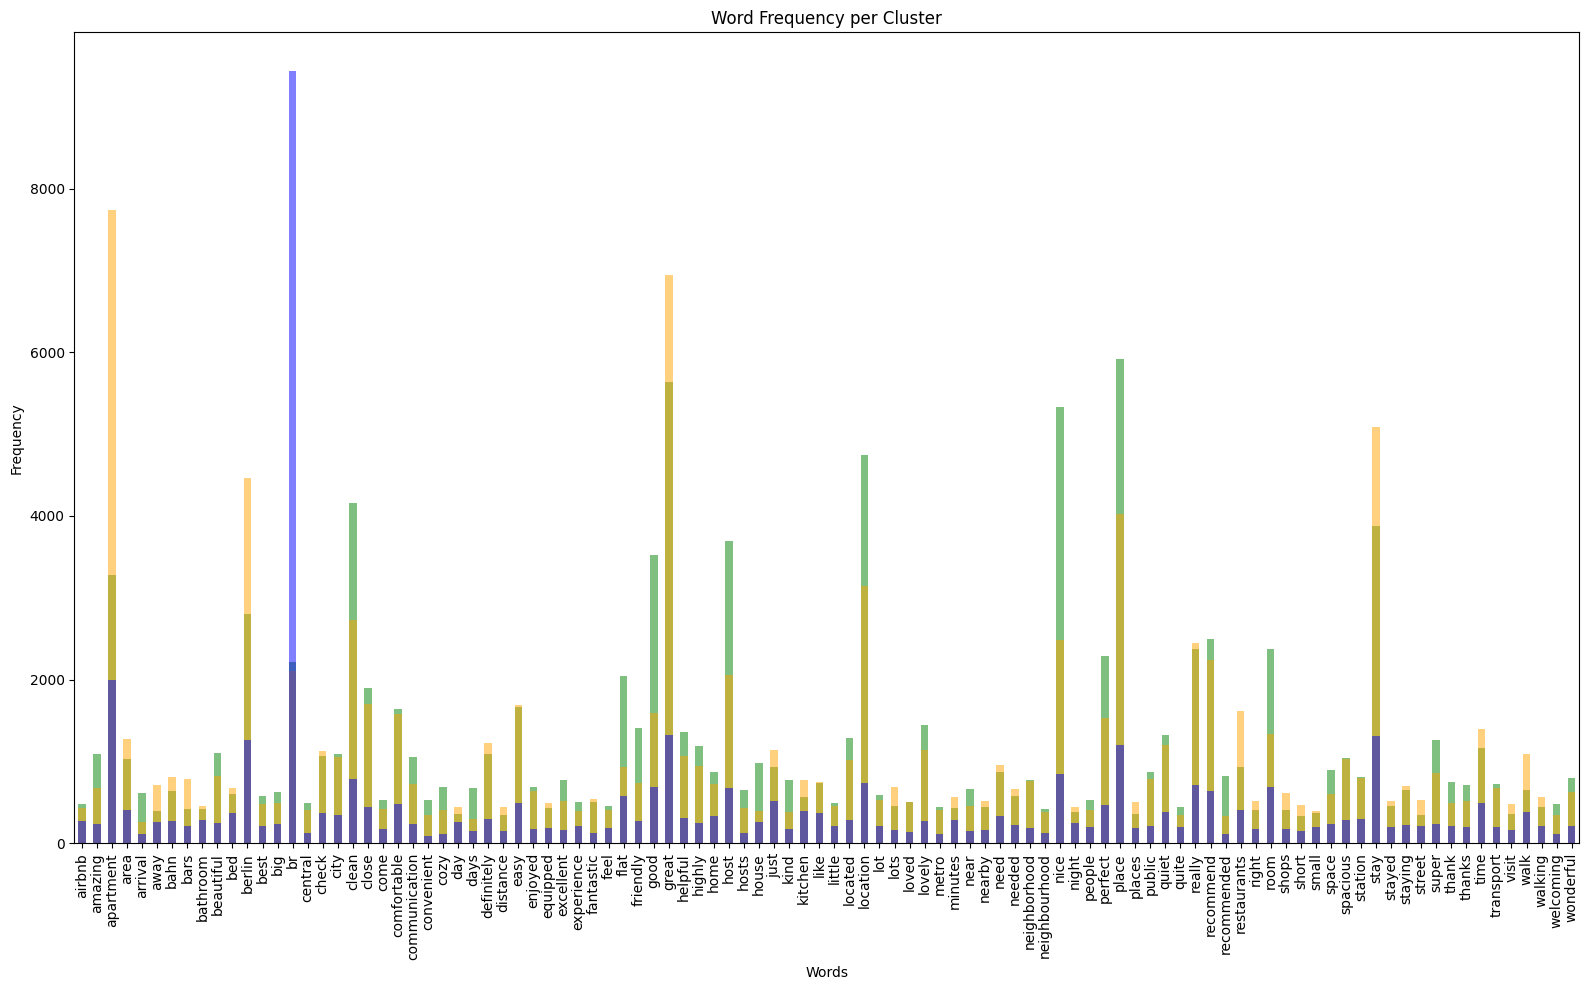

In [13]:
#Imports
import seaborn as sns
import numpy as np

#Reduce dimensionality for plotting the clustering result
pca = PCA(n_components=2, random_state=123)
pca.fit(data)
reduced_data = pca.transform(data)

#Create a visualization DataFrame of the two principal components and the clustering results
visualizing_data = pd.DataFrame(reduced_data, 
                                columns=['PC1','PC2'])

target = pd.DataFrame(km_fitted.labels_,columns=['cluster'])
visualizing_data = pd.concat([visualizing_data,target],axis=1)

#Create Scatterplot of first two principal components colored by clustering results
plt.figure(figsize=(16,10))
plt.title('Clustering Results: First Two Principal Components')
sns.scatterplot(x='PC1',y='PC2',hue='cluster',data=visualizing_data)
plt.legend()
plt.tight_layout()
plt.show()

#Get unique values for clustering results
clusters = target['cluster'].unique()

#Print four random examples of each cluster
for i in clusters:

    counter = 0

    while counter <= 3:
        
        #Choose random index to get samples of clustering result
        idx = np.random.choice(len(df),1)

        #Get value on random location
        v = target['cluster'].iloc[idx].values[0]

        while v != i:

            #Get new index until value at target[idx] is i
            idx = np.random.choice(len(df),1)
            v = target['cluster'].iloc[idx].values[0]

        #Print random instance
        print('Data of sample: ', df.iloc[idx]['comments'].values[0])
        print('Cluster of sample: ', i)

        counter += 1
    
    print('')

#Create Barplot of sum of words of different clusters
data_with_clusters = pd.concat([data,target],axis=1)
colors=['green','blue','orange','yellow','red']

for i in clusters:

    #Subset data of only one cluster
    temp_df = data_with_clusters.loc[data_with_clusters['cluster'] == i]
    temp_df = temp_df.drop(['cluster'],axis=1)
    sum_of_features = temp_df.sum()

    #Create Plot
    sum_of_features.plot.bar(figsize=(16,10),color=colors[i],alpha=0.5)

#Set title and layout
title = 'Word Frequency per Cluster'
plt.title(title)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Das Clustering-Ergebnis ist nicht wirlich gut:

Die drei Cluster überlappen stark (besonders Cluster 0 und 1)... es gibt keine klare räumliche Trennung, was auf schwache Clusterbildung hindeutet.
- Barplots: Die Wortverteilungen sind zwischen allen Clustern sehr ähnlich. Alle Cluster enthalten die gleichen häufigen Wörter ("great", "location", "apartment", "stay", "nice")-> keine erkennbaren thematischen Unterschiede
- Mögliche ursache vllt. durch den count-vectorizer mit wert 100

Jedenfalls keine wirklich gute aussage zu den cluster treffbar
